In [1]:
from models.preparation import import_data, get_dtypes, compute_correlation, variables_selection, encode, normalise
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [2]:
df = import_data()
df['pdays']=df['pdays'].replace(999, -1)
for column in df.select_dtypes(include='object').columns:
    df[column] = df[column].astype('category')

In [3]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [4]:
# trasform age to a categrory variable
df['age_cat'] = pd.cut(df['age'], 
                       bins=[0, 23-0.01, 30-0.01, 40-0.01, 60-0.01, 100], 
                       labels=['[0-23[', '[23-30[', '[30-40[', '[40-60[', '60<'])

In [5]:
from scipy.stats import chi2_contingency
def cramers_corrected_stat(x,y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)
            
        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True
    
        chi2 = chi2_contingency(conf_matrix, correction=correct)[0]
            
        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

In [6]:
cramers_corrected_stat(df['job'], df['age_cat'])

0.356268

In [7]:
X=pd.get_dummies(df[['default', 'housing', 'loan']], drop_first=True)

In [8]:
X

,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,False,False,False,False,False,False
1,True,False,False,False,False,False
2,False,False,False,True,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,True
...,...,...,...,...,...,...
41183,False,False,False,True,False,False
41184,False,False,False,False,False,False
41185,False,False,False,True,False,False
41186,False,False,False,False,False,False


In [9]:
X[["default_unknown","default_yes","housing_unknown","housing_yes","loan_unknown","loan_yes"]]
X[["default_unknown","housing_unknown","loan_unknown"]].sum(axis=1).value_counts()

0    31828
1     8370
2      763
3      227
Name: count, dtype: int64

In [10]:
df['debt_score'] = df[['housing', 'loan']].apply(lambda x: x.astype(str).map({'no':0, 'yes':1, 'unknown':0.4}).sum(), axis=1)

In [11]:
df['debt_score'].value_counts()

debt_score
1.0    20442
0.0    16065
2.0     3691
0.8      990
Name: count, dtype: int64

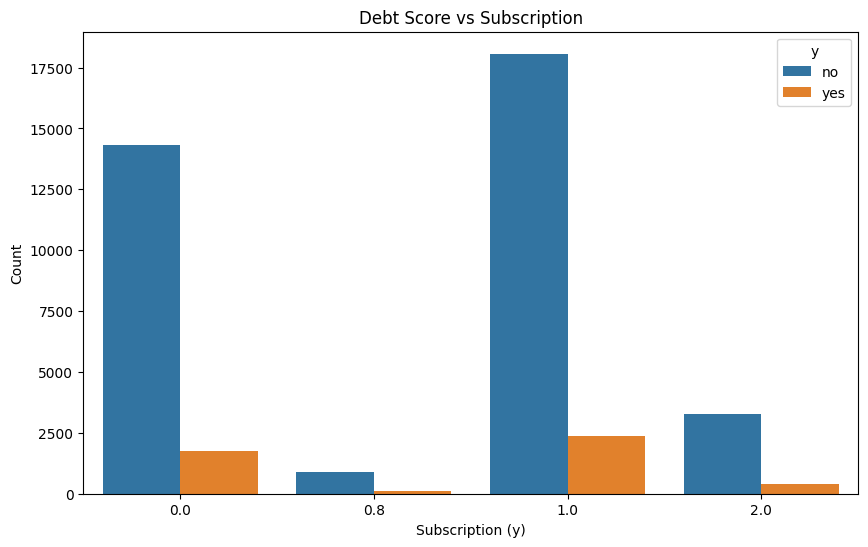

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert debt_score to a categorical variable
df['debt_score'] = df['debt_score'].astype('category')


# Plot the count of debt_score for each subscription category
plt.figure(figsize=(10, 6))
sns.countplot(hue='y', x='debt_score', data=df)
plt.title('Debt Score vs Subscription')
plt.xlabel('Subscription (y)')
plt.ylabel('Count')
plt.show()

In [13]:
# Create campaign_efficiency variable
df['campaign_efficiency'] = df.apply(lambda row: row['previous'] / row['campaign'] if row['poutcome'] == 'success' else 0, axis=1)
df['contacted_before_successed'] = df['poutcome'].apply(lambda x: 1 if x == 'success' else 0)


In [14]:
from scipy.stats import pointbiserialr

# Calculate the Point Biserial Correlation Coefficient
correlation, p_value = pointbiserialr(df['debt_score'], df['y'].cat.codes)
print(f"Point Biserial Correlation between contacted_before_successed and y: {correlation}")
print(f"P-value: {p_value}")

Point Biserial Correlation between contacted_before_successed and y: 0.006401351167525432
P-value: 0.19390377248019924


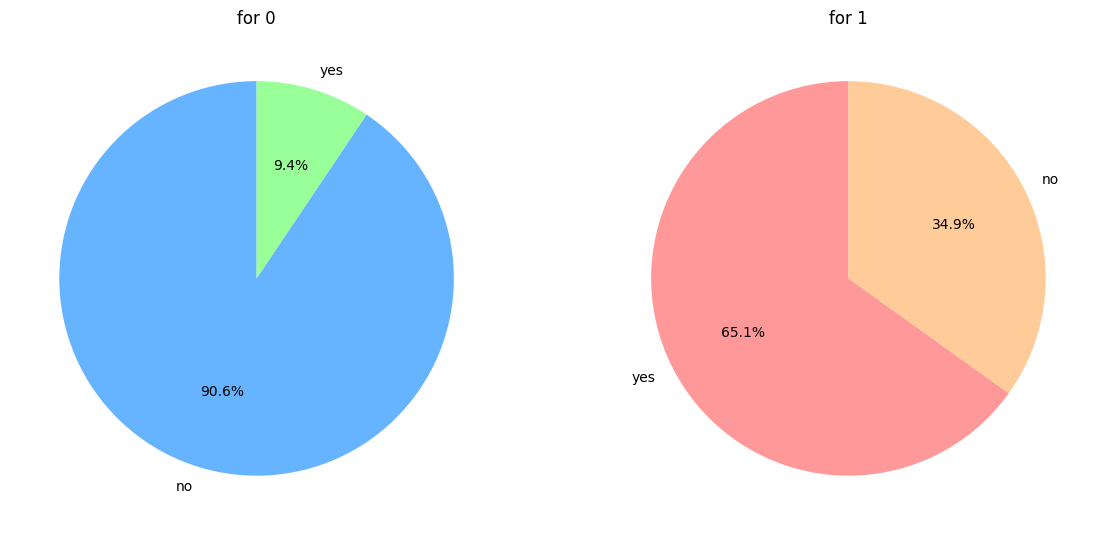

In [15]:
# Plot pie charts for contacted_before_successed values
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for contacted_before_successed == 0
df[df['contacted_before_successed'] == 0]['y'].value_counts().plot.pie(
    autopct='%1.1f%%', ax=axes[0], startangle=90, colors=['#66b3ff','#99ff99'])
axes[0].set_title('for 0')
axes[0].set_ylabel('')

# Pie chart for contacted_before_successed == 1
df[df['contacted_before_successed'] == 1]['y'].value_counts().plot.pie(
    autopct='%1.1f%%', ax=axes[1], startangle=90, colors=['#ff9999','#ffcc99'])
axes[1].set_title('for 1')
axes[1].set_ylabel('')

plt.show()

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Extract the relevant columns
economic_factors = df[['cons.price.idx', 'cons.conf.idx', 'emp.var.rate']]

# Standardize the data
scaler = MinMaxScaler()
economic_factors_scaled = scaler.fit_transform(economic_factors)

# Apply PCA
pca = PCA(n_components=1)


In [17]:
pca.fit_transform(economic_factors_scaled)

array([[-0.28356527],
       [-0.28356527],
       [-0.28356527],
       ...,
       [ 0.01360692],
       [ 0.01360692],
       [ 0.01360692]])

In [18]:
df['economic_sentiment_pca'] = pca.fit_transform(economic_factors_scaled)

# Calculate weighted average
# Calculate the correlation of each economic factor with 'y'
correlations = economic_factors.apply(lambda x: x.corr(df['y'].cat.codes))

# Normalize the correlations to sum to 1
weights = correlations / correlations.sum()

# Calculate the weighted average
df['economic_sentiment_weighted'] = (economic_factors * weights.values).sum(axis=1)

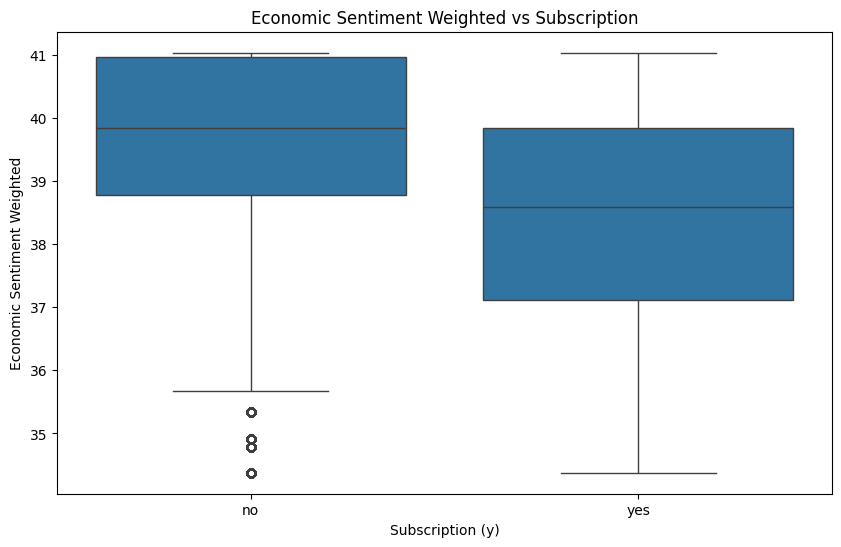

In [19]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='y', y='economic_sentiment_weighted', data=df)
plt.title('Economic Sentiment Weighted vs Subscription')
plt.xlabel('Subscription (y)')
plt.ylabel('Economic Sentiment Weighted')
plt.show()